In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import sklearn
import scanpy as sc

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

#Normalize
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
cffi                1.15.1
colorama            0.4.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.9.1
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.9.11
ipykernel           6.15.1
ipython_genutils    0.2.0
ipywidgets          7.7.1
jedi                0.18.1
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
leidenalg           0.8.10
llvmlite            0.38.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
natsort             8.1.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.55.2
numexpr             2.8.3
numpy               1.22.4
packaging

/home/wma/miniconda3/envs/agreda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
normalizing counts per cell


/home/wma/miniconda3/envs/agreda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [3]:
adata_spatial_anterior.X

<2695x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 15850802 stored elements in Compressed Sparse Row format>

In [4]:
adata.obs_names

Index(['AAACAAGTATCTCCCA-1', 'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1',
       'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1',
       'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1',
       'AAACCGTTCGTCCAGG-1',
       ...
       'TTGTGGCCCTGACAGT-1', 'TTGTGGTAGGAGGGAT-1', 'TTGTGTATGCCACCAA-1',
       'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1',
       'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1',
       'TTGTTTCCATACAACT-1'],
      dtype='object', length=3355)

In [5]:
adata.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [6]:
adata.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGCTTTCAGAAG-1,1,43,9
AAACAGGGTCTATATT-1,1,47,13
...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64
TTGTTGTGTGTCAAGA-1,1,31,77
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30


In [7]:
adata.to_df().std()

Xkr4          0.122429
Gm1992        0.024551
Gm19938       0.127411
Gm37381       0.000000
Rp1           0.024450
                ...   
AC124606.1    0.000000
AC133095.2    0.000000
AC133095.1    0.000000
AC234645.1    0.000000
AC149090.1    2.121894
Length: 32285, dtype: float32

# Single cell Data: GSE115746


In [8]:
# adata_cortex = sc.read_csv('./data/GSE115746_cells_exon_counts.csv').T
# adata_cortex.write_h5ad('./data/GSE115746_cells_exon_counts.h5ad')

In [9]:
adata_cortex = sc.read_h5ad('./data/GSE115746_cells_exon_counts.h5ad')

In [10]:
adata_cortex_meta = pd.read_csv('./data/GSE115746_complete_metadata_28706-cells.csv', index_col=0)
adata_cortex_meta_ = adata_cortex_meta.loc[adata_cortex.obs.index,]

adata_cortex.obs = adata_cortex_meta_
adata_cortex.var_names_make_unique()  

In [11]:
#Preprocessing
adata_cortex.var['mt'] = adata_cortex.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_cortex, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pp.normalize_total(adata_cortex)

#PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_cortex, svd_solver='arpack')
# sc.pp.neighbors(adata_cortex, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_cortex)
# sc.tl.leiden(adata_cortex, resolution = 0.5)
# sc.pl.umap(adata_cortex, color=['leiden','cell_subclass'])

normalizing counts per cell
    finished (0:00:00)


In [12]:
# genelists=adata_cortex.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.head(5)

# num_markers=10
# res_genes = []
# for column in df_genelists.head(num_markers): 
#     res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(adata_cortex.var.index.tolist()))

adata_spatial_anterior.var_names_make_unique() 
inter_genes = [val for val in res_genes_ if val in adata_spatial_anterior.var.index]
print('Selected Feature Gene number',len(inter_genes))
adata_cortex = adata_cortex[:,inter_genes]

adata_spatial_anterior = adata_spatial_anterior[:,inter_genes]

Selected Feature Gene number 24591


In [13]:
from sklearn.preprocessing import OneHotEncoder

def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    # Define empty lists
    Xs_new, ys_new =[], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples,nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction/np.sum(fraction)
        fraction = np.reshape(fraction, (nmix,1))
        
        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix*fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex])*fraction
        XX_ = np.sum(XX, axis=0)
        
        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        Xs_new.append(XX_)

    Xs_new = np.asarray(Xs_new)
    ys_new = np.asarray(ys_new)

    return Xs_new, ys_new

In [14]:
mat_sc = adata_cortex.X
mat_sp = adata_spatial_anterior.X.todense()

df_sc = adata_cortex.obs

lab_sc_sub = df_sc.cell_subclass
sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), set(lab_sc_sub)))
sc_sub_dict2 = dict((y,x) for x,y in sc_sub_dict.items())
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype='int')

In [15]:
sc_mix, lab_mix = random_mix(mat_sc, lab_sc_num, nmix=8, n_samples=len(mat_sp))

In [16]:
def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)
    # return (arr-np.reshape(np.min(arr,axis=1), (arrd,1)))/np.reshape((np.max(arr, axis=1)-np.min(arr,axis=1)),(arrd,1))
    return arr

sc_mix_s = log_minmaxscale(sc_mix)
mat_sp_s = log_minmaxscale(mat_sp)
mat_sc_s = log_minmaxscale(mat_sc)

del sc_mix
del mat_sp
del mat_sc
del mat_sc_s

In [17]:
all_z_df = pd.concat([pd.DataFrame(sc_mix_s), pd.DataFrame(mat_sp_s)], keys = [0, 1])

In [18]:
all_z_df

0         1         2      3         4         5         6      \
0 0     3.291849  0.895184  6.727623    0.0  3.545153  2.278736  1.648604   
  1     3.063513  0.760560  6.424692    0.0  3.975779  2.517863  2.943672   
  2     3.084158  2.279392  6.686137    0.0  2.116087  2.776048  2.320264   
  3     4.078547  0.653269  6.508508    0.0  0.759823  3.806365  2.097194   
  4     3.619730  1.345003  7.020529    0.0  2.960520  3.372127  1.520744   
...          ...       ...       ...    ...       ...       ...       ...   
1 2690  0.636183  0.000000  2.093596    0.0  0.636183  0.000000  0.000000   
  2691  0.608303  0.608303  2.041025    0.0  0.608303  0.000000  0.000000   
  2692  0.000000  0.000000  1.863065    0.0  0.000000  0.000000  0.736538   
  2693  0.893635  0.000000  2.407665    0.0  0.893635  0.893635  0.893635   
  2694  0.000000  0.000000  2.324392    0.0  1.404500  0.000000  0.000000   

        7         8         9      ...     24581  24582     24583     24584  \
0 0       0.0  0.000000  3.188491  ...  3.278361    0.0  0.000000  4.239334   
  1       0.0  0.173313  3.712222  ...  3.065415    0.0  1.677560  5.034080   
  2       0.0  0.000000  3.777568  ...  4.092159    0.0  0.000000  5.154675   
  3       0.0  0.869394  3.683746  ...  4.055329    0.0  0.000000  4.609217   
  4       0.0  0.150221  3.869210  ...  2.230892    0.0  1.364363  3.821401   
...       ...       ...       ...  ...       ...    ...       ...       ...   
1 2690    0.0  0.000000  1.299583  ...  0.000000    0.0  0.000000  1.516669   
  2691    0.0  0.000000  0.608303  ...  0.000000    0.0  0.000000  0.000000   
  2692    0.0  0.000000  0.000000  ...  0.736538    0.0  0.000000  0.000000   
  2693    0.0  0.000000  0.893635  ...  0.000000    0.0  0.000000  1.673725   
  2694    0.0  0.000000  0.930882  ...  0.000000    0.0  0.000000  0.930882   

        24585     24586     24587     24588     24589     24590  
0 0       0.0  3.546451  0.000000  0.000000  0.000000  4.924347  
  1       0.0  3.966643  0.000000  0.000000  0.000000  2.661019  
  2       0.0  3.775599  1.448429  0.000000  0.000000  4.239759  
  3       0.0  3.492247  0.000000  0.000000  0.000000  3.429642  
  4       0.0  2.408597  2.858229  2.497967  0.187827  4.017631  
...       ...       ...       ...       ...       ...       ...  
1 2690    0.0  0.000000  0.636183  0.000000  0.000000  0.000000  
  2691    0.0  0.000000  0.608303  0.000000  0.000000  0.000000  
  2692    0.0  0.000000  0.736538  0.000000  0.000000  0.736538  
  2693    0.0  0.000000  1.357894  0.000000  0.000000  0.893635  
  2694    0.0  0.000000  0.000000  0.930882  0.000000  1.404500  

[5390 rows x 24591 columns]

In [19]:
from sklearn.preprocessing import StandardScaler

all_z_df.loc[0] = StandardScaler().fit_transform(all_z_df.loc[0])
all_z_df.loc[1] = StandardScaler().fit_transform(all_z_df.loc[1])

In [20]:
all_z_df

0         1         2         3         4         5         6      \
0 0    -0.483227 -0.492269  0.036006 -0.026845  1.128783 -0.762449 -0.656094   
  1    -0.826324 -0.623021 -1.229184 -0.026845  1.533055 -0.479053  0.794409   
  2    -0.795302  0.852131 -0.137260 -0.026845 -0.212827 -0.173069  0.096180   
  3     0.698856 -0.727227 -0.879127 -0.026845 -1.486090  1.047992 -0.153663   
  4     0.009444 -0.055386  1.259328 -0.026845  0.579929  0.533362 -0.799299   
...          ...       ...       ...       ...       ...       ...       ...   
1 2690  1.011484 -0.351230  0.240584  0.000000  0.364922 -0.542379 -0.300052   
  2691  0.941936  2.027001  0.144927  0.000000  0.309926 -0.542379 -0.300052   
  2692 -0.575558 -0.351230 -0.178878  0.000000 -0.890025 -0.542379  3.385845   
  2693  1.653734 -0.351230  0.812046  0.000000  0.872778  1.956167  4.172017   
  2694 -0.575558 -0.351230  0.660528  0.000000  1.880519 -0.542379 -0.300052   

           7         8         9      ...     24581     24582     24583  \
0 0    -0.118576 -0.680214 -1.671223  ...  0.123284 -0.031778 -0.703237   
  1    -0.118576 -0.572556 -0.137621  ... -0.119617 -0.031778  0.730441   
  2    -0.118576 -0.680214  0.053725  ...  1.051560 -0.031778 -0.703237   
  3    -0.118576 -0.140168 -0.221006  ...  1.009549 -0.031778 -0.703237   
  4    -0.118576 -0.586900  0.322074  ... -1.071534 -0.031778  0.462777   
...          ...       ...       ...  ...       ...       ...       ...   
1 2690  0.000000 -0.305322  0.981203  ... -0.534170  0.000000 -0.160347   
  2691  0.000000 -0.305322 -0.235437  ... -0.534170  0.000000 -0.160347   
  2692  0.000000 -0.305322 -1.306040  ...  1.530380  0.000000 -0.160347   
  2693  0.000000 -0.305322  0.266743  ... -0.534170  0.000000 -0.160347   
  2694  0.000000 -0.305322  0.332296  ... -0.534170  0.000000 -0.160347   

           24584     24585     24586     24587     24588     24589     24590  
0 0    -0.444010 -0.095082  0.182143 -1.240707 -0.343107 -0.386083  1.818586  
  1     1.588817 -0.095082  0.731809 -1.240707 -0.343107 -0.386083 -0.886985  
  2     1.897277 -0.095082  0.481899 -0.011385 -0.343107 -0.386083  1.000233  
  3     0.502087 -0.095082  0.111237 -1.240707 -0.343107 -0.386083  0.031823  
  4    -1.513015 -0.095082 -1.306320  1.185152  3.272831 -0.134001  0.734702  
...          ...       ...       ...       ...       ...       ...       ...  
1 2690  0.727153  0.000000 -0.418543  0.591672 -0.233778 -0.121760 -1.108360  
  2691 -1.688451  0.000000 -0.418543  0.537090 -0.233778 -0.121760 -1.108360  
  2692 -1.688451  0.000000 -0.418543  0.788144 -0.233778 -0.121760 -0.237540  
  2693  0.977297  0.000000 -0.418543  2.004619 -0.233778 -0.121760 -0.051801  
  2694 -0.205833  0.000000 -0.418543 -0.653830  4.954301 -0.121760  0.552202  

[5390 rows x 24591 columns]

In [21]:
import umap
from sklearn.decomposition import PCA


from sklearn.manifold import TSNE


def get_PCA_2D(X):
    pca = PCA(n_components=2)
    pca.fit(X)
    return pca.transform(X)

def plot_scatter(X, labels, legend=None, title=""):
    markers=['o','o','o','^']
    n_clusters = labels.max() + 1
    
    if legend is None:
        legend = [str(i) for i in range(n_clusters)]
    
    for i in range(n_clusters):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        print(i, len(points))
        plt.scatter(points[:, 0], points[:, 1], label=legend[i], marker=markers[i%len(markers)])
    
    if labels.min()==-1:
        points = np.array([X[j] for j in range(len(X)) if labels[j] == -1])
        plt.scatter(points[:, 0], points[:, 1], c='black', label='-1')
     
    plt.title(title)
    plt.legend()
    # plt.show()
    
def plot_scatter_subfig(X, labels, ax, legend=None, title=""):
    markers=['.','.','o','^']
    n_clusters = labels.max() + 1
    if legend is None:
        legend = [str(i) for i in range(n_clusters)]
        
    for i in range(n_clusters):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        ax.scatter(points[:, 0], points[:, 1], label=legend[i], marker=markers[i%len(markers)])
    ax.legend(legend)
    if labels.min()==-1:
        points = np.array([X[j] for j in range(len(X)) if labels[j] == -1])
        ax.scatter(points[:, 0], points[:, 1], c='black', label='-1')
        
    ax.set_title(title)

In [22]:
# data_pca = get_PCA_2D(all_df)
# data_umap = umap.UMAP().fit_transform(all_df)
# data_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=374).fit_transform(all_df)

data_pca_z = get_PCA_2D(all_z_df)
data_umap_z = umap.UMAP().fit_transform(all_z_df)
data_tsne_z = TSNE(n_components=2, learning_rate='auto', init='random', random_state=374).fit_transform(all_z_df)

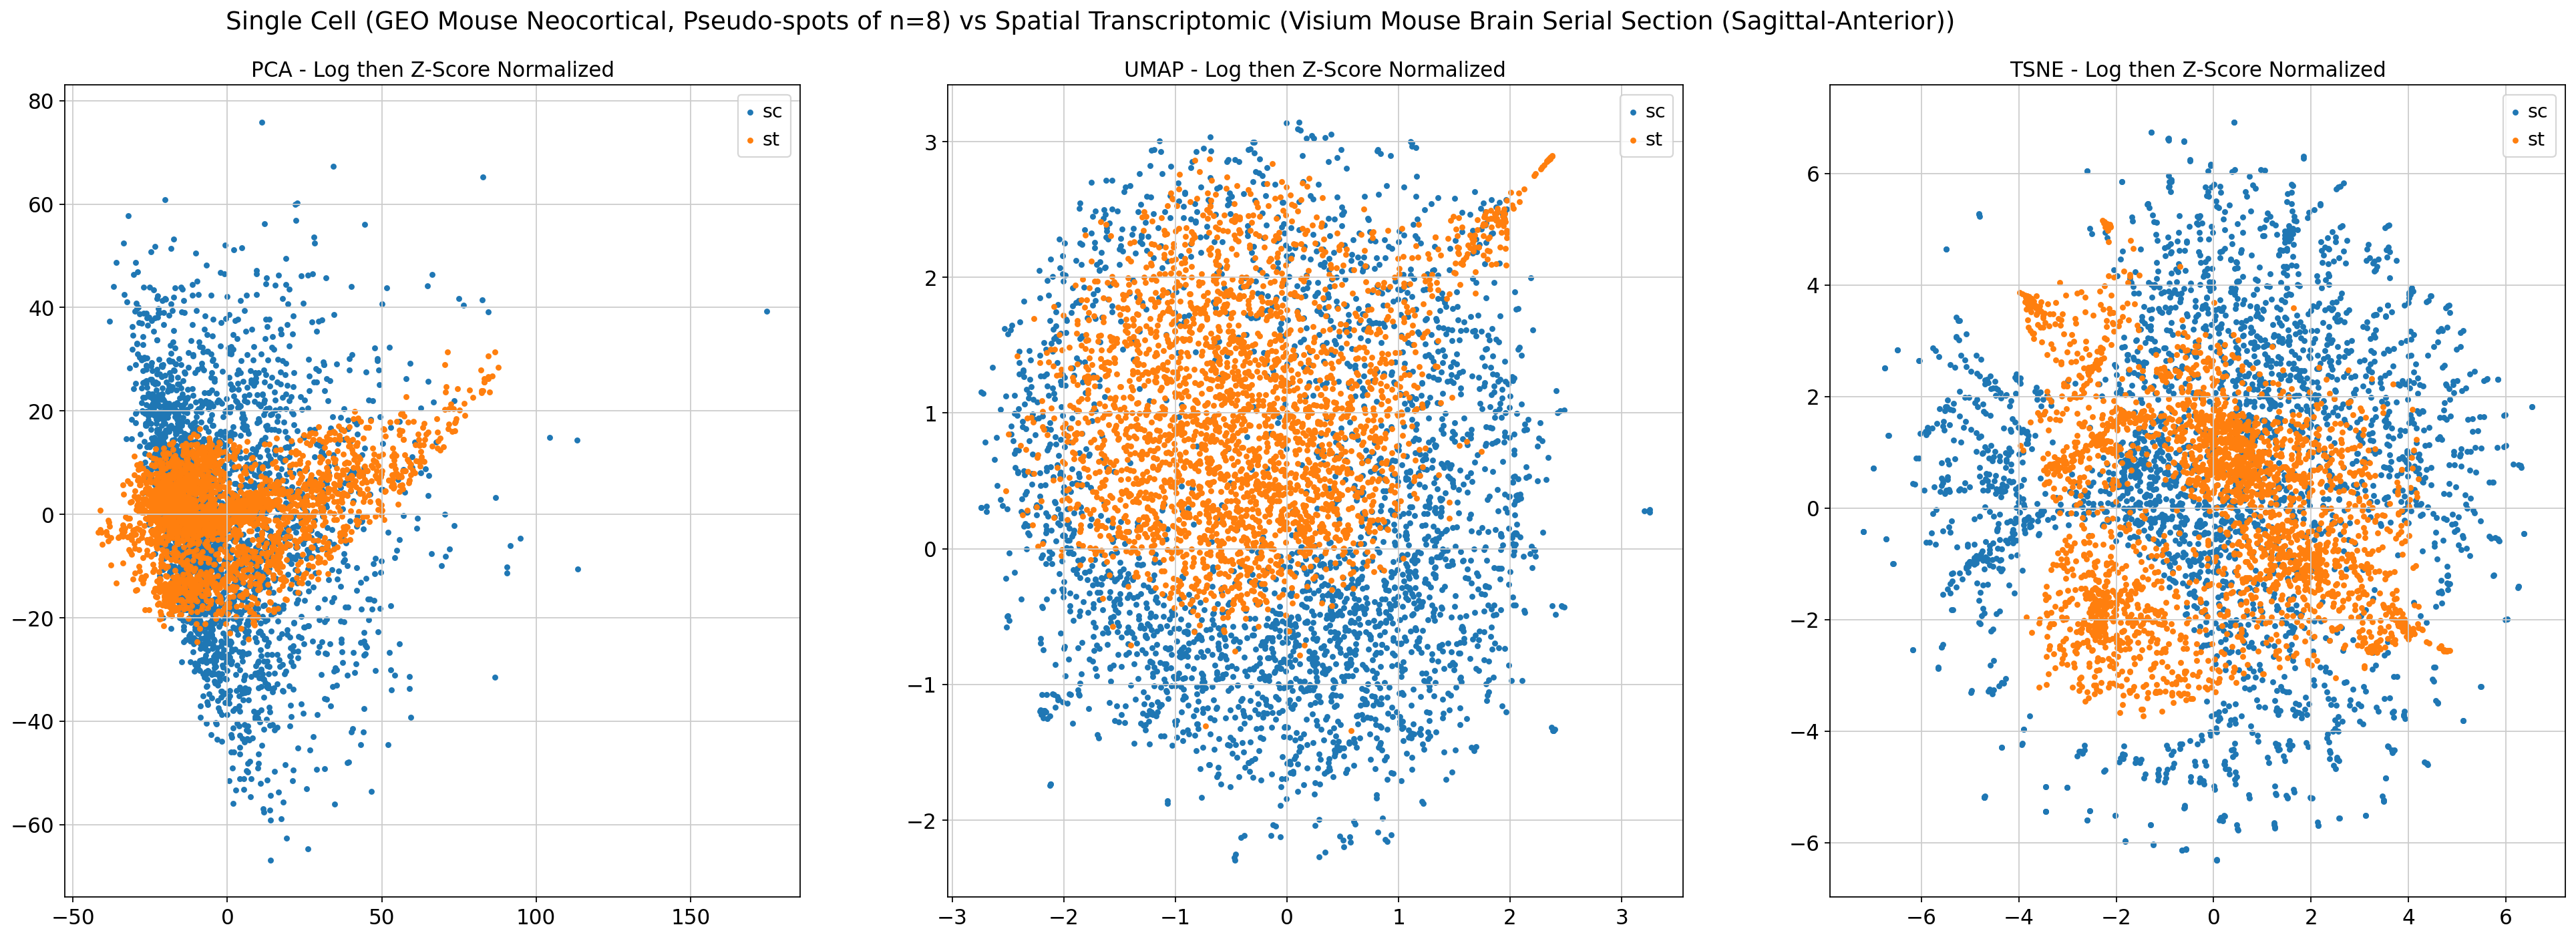

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))
# plot_scatter_subfig(data_pca, all_df.index.get_level_values(0).to_numpy(), axs[0][0], title=f'PCA - Min-Max Normalized', legend=['sc', 'st'])
# plot_scatter_subfig(data_umap, all_df.index.get_level_values(0).to_numpy(), axs[0][1], title=f'UMAP - Min-Max Normalized', legend=['sc', 'st'])

plot_scatter_subfig(data_pca_z, all_z_df.index.get_level_values(0).to_numpy(), axs[0], title=f'PCA - Log then Z-Score Normalized', legend=['sc', 'st'])
plot_scatter_subfig(data_umap_z, all_z_df.index.get_level_values(0).to_numpy(), axs[1], title=f'UMAP - Log then Z-Score Normalized', legend=['sc', 'st'])
plot_scatter_subfig(data_tsne_z, all_z_df.index.get_level_values(0).to_numpy(), axs[2], title=f'TSNE - Log then Z-Score Normalized', legend=['sc', 'st'])


    
    
fig.suptitle(f'Single Cell (GEO Mouse Neocortical, Pseudo-spots of n=8) vs Spatial Transcriptomic (Visium Mouse Brain Serial Section (Sagittal-Anterior))')

plt.show(block=False)

In [24]:
Z = sch.linkage(all_z_df, method='ward', metric = 'euclidean')

/tmp/ipykernel_8833/856991027.py:72: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(neg, cax=cbaxes, orientation='horizontal',


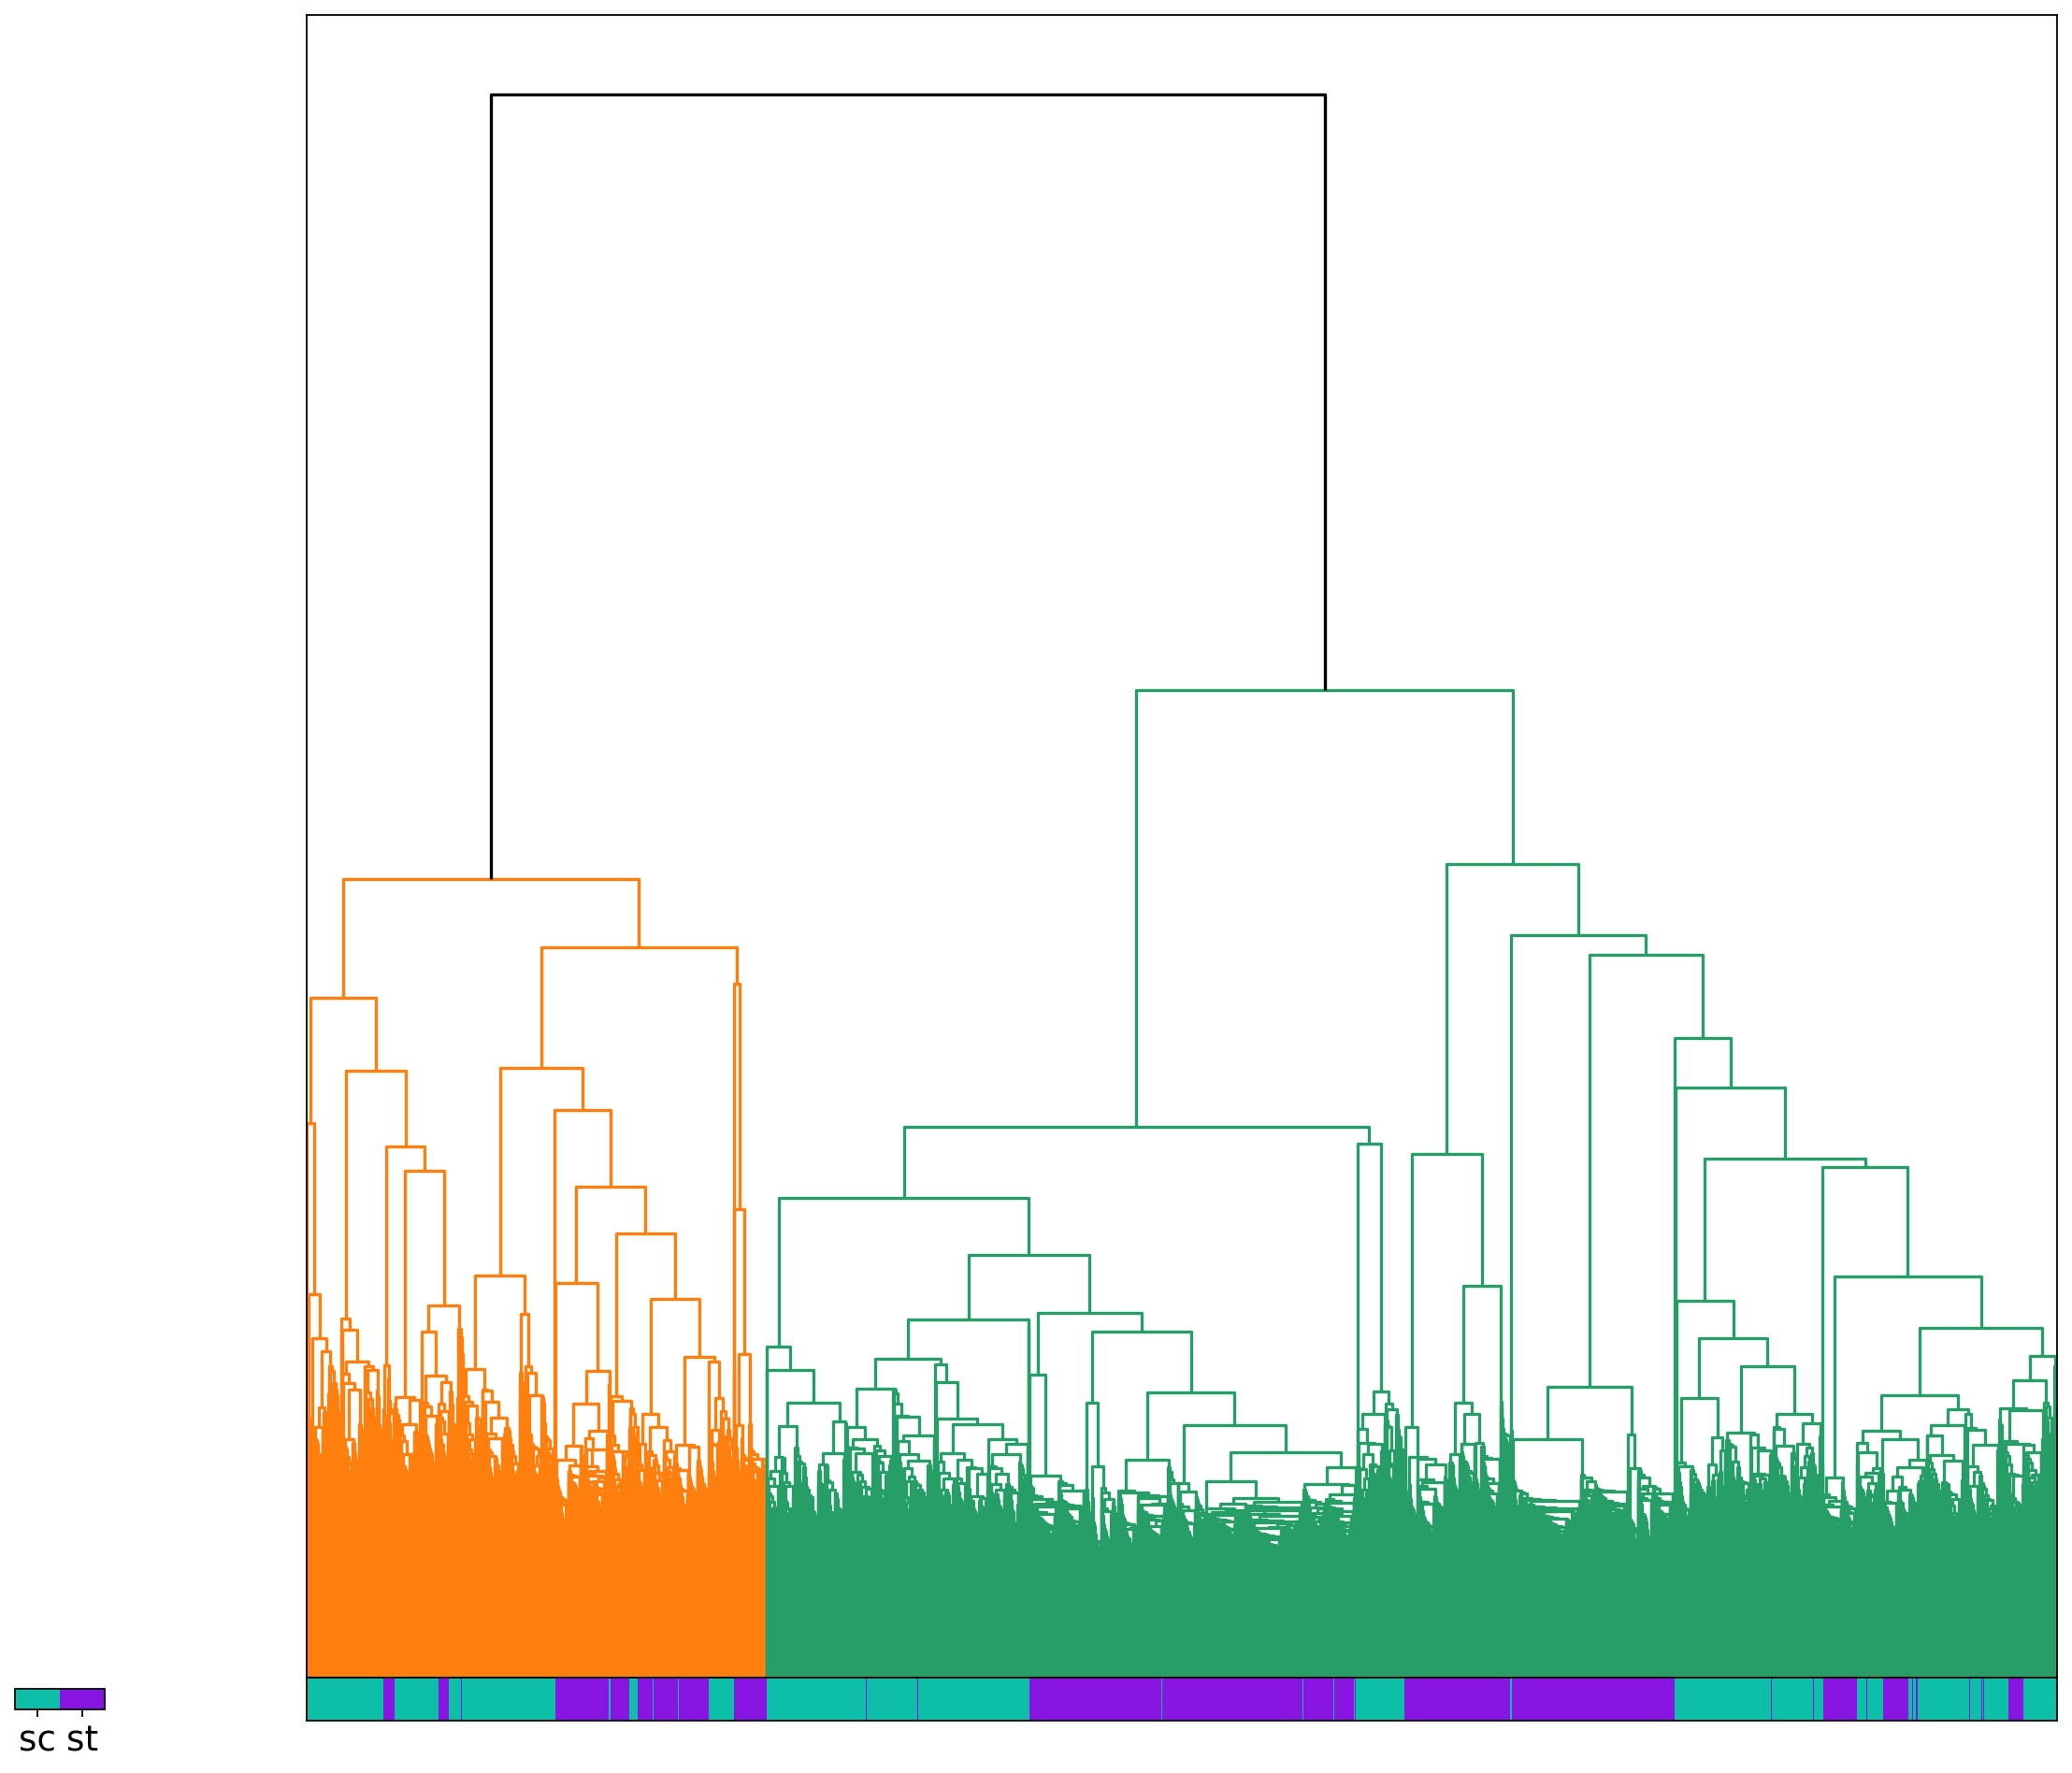

In [25]:
# # import matplotlib.cm
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)),
        N=n
    )
    return new_cmap

from matplotlib.colors import rgb2hex
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2,
                       1,
                       height_ratios=[39, 1],
                       hspace=0.00)

ax2 = fig.add_subplot(gs[0])#add_axes([0,0.75,1,0.45])




clust_labels = all_z_df.index.get_level_values(0).to_numpy()

Z2 = sch.dendrogram(Z, color_threshold = Z[len(Z) - 2+1,2],  above_threshold_color='k')

ax2.set_xticks([])
ax2.set_yticks([])

# label clusters
clust_labels_dendo = clust_labels[Z2['leaves']]

idx2 = Z2['leaves']





axb = fig.add_subplot(gs[1])


cat_vals = clust_labels[idx2]

n=(~np.isnan(np.unique(cat_vals))).sum()

cmap = plt.cm.get_cmap('bwr', n)
cmap = mcolors.ListedColormap(['#0dbea8', '#8714e1'])

cmap.set_bad('white',1.)

neg = axb.matshow(np.atleast_2d(cat_vals),
                       aspect='auto',
                       origin='lower',
                            cmap=cmap)

pos1 = axb.get_position() # get the original position 
cbaxes = fig.add_axes([0.05, pos1.y0 + pos1.height / 4.0,  0.08*(~np.isnan(np.unique(cat_vals))).sum()/4, pos1.height / 2.0])
ticks = np.unique(cat_vals[~np.isnan(cat_vals)])
cbar = fig.colorbar(neg, cax=cbaxes, orientation='horizontal',
                    ticks=[tick-(tick-ticks.mean())/len(ticks) for tick in ticks])
#                             ticks=ticks
#         tick_locs = (np.arange(n) + 0.5)*(n-1)/n
#         cbar.ax.set_ticks(tick_locs)

cbar.ax.set_xticklabels(['sc', 'st'],rotation=0,fontsize='large')


axb.set_yticks([])
axb.set_xticks([])
    # axb.text(-0.01,
    #      0.5,
    #      cat_bar_var,
    #      horizontalalignment='right',
    #      verticalalignment='center',
    #      transform=bar_axs_cat[i].transAxes,
    #                     fontsize='large'
    #     )
#     bar_axs_cat[i].legend(np.unique(labels[cat_bar_var][[(legend[cat_bar_var][label_name] != 'Indeterminate') for label_name in labels[cat_bar_var]]]).tolist(),
#                           [x for x in legend[cat_bar_var] if x != 'Indeterminate'])
    


#     for vert_po in vert_pos:
#         bar_axs_cat[i].axvline(vert_po, color='k', alpha=1)

# pos_hm = axmatrix.get_position()
# cbaxes = fig.add_axes([0.05, pos_hm.y0+ pos1.height*2, 0.13, pos1.height])  #[left, bottom, width, height]
# cbar = plt.colorbar(im,
#                     cax=cbaxes,
#                     orientation='horizontal',
#                     ticks=[1/(1+np.exp(steeepness*2)),
#                            1/(1+np.exp(steeepness*1)),
#                            1/(1+np.exp(steeepness*0)),
#                            1/(1+np.exp(-steeepness*1)),
#                            1/(1+np.exp(-steeepness*2))])
# cbar.ax.set_xticklabels(['-2', '-1', '0', '1', '2'], fontsize='xx-large')  # vertically oriented colorbar
# cbar.ax.xaxis.tick_left()

# fig.suptitle("\n".join(wrap(f'Dendogram and Heatmap - {params_clust["num_clusters"]} Clusters - subset={subset_str}', 100)),y=0.9)

# plt.savefig(os.path.join(results_dir_out, f'Dendo_heat-{params_clust["num_clusters"]}_clusters.png'), dpi=300)
plt.show(block=False)


In [26]:
agglo_clust = sch.cut_tree(Z, n_clusters=2).T[0]

In [34]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

clf =  RandomForestClassifier(random_state=23, n_jobs=-1)
# clf = SVC(gamma=2, C=1)
# clf = LogisticRegression()



X_train, X_test, y_train, y_test = train_test_split(
    all_z_df, all_z_df.index.get_level_values(0).to_numpy(), test_size=0.2, random_state=256
)

clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(1.0, 1.0)

In [35]:
score

1.0

In [36]:
y_test.mean(), y_train.mean()

(0.5009276437847866, 0.4997680890538033)

In [37]:
clf = SVC(random_state=26)
# clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(0.849721706864564, 0.988404452690167)

In [38]:
# clf = SVC(gamma=2, C=1)
clf = LogisticRegression(solver='newton-cg', max_iter=1000, n_jobs=-1, random_state=26)
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(0.0009276437847866419, 1.0)

In [40]:
y_test.size

1078

In [41]:
y_train.size

4312